In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
def read_results(file="trade_logs/results_trades.log",exitreason=None,skiprows=0):
    with open(file,"r") as f:
        data = f.readlines()
    split_data = [d[:-1].split(",") for d in data[skiprows:]]
    opens=[]
    closes=[]
    for ticker,interval,openprice,closeprice,dfname,starttime,exittime,reason in split_data:
        if exitreason:
            if exitreason!=reason:
                continue
        opens.append(float(openprice.split("open")[-1]))
        closes.append(float(closeprice.split("closeprice")[-1])) 
            
    profits = (np.asarray(closes)-np.asarray(opens))/np.asarray(opens)
    startingfund=1
    endingfund = startingfund
    equity = [startingfund]
    for p in profits:
        endingfund *= (1+p)
        equity.append(endingfund)
    return equity,profits
def plot_profits(equity,profits,title=""):
    fig,axx = plt.subplots(2,1,sharex=True)
    ax=axx[0]
    ax.plot(equity,marker="x")
    ax.plot(np.cumsum([0]+profits)+1)
    ax.set_ylabel("equity")
    strr =f"gain={equity[-1]-1:.2%}, trades{len(profits)}, win%{sum(profits>0)/len(profits)*100:.2f}%"
    strr+=f", avg{(np.mean(profits))*100:.2f}%"
    ax.text(0.01,0.99,strr, ha="left",va="top",transform=ax.transAxes)
    ax.set_title(title)
    ax=axx[1]
    ax.set_xlabel("trades")
    ax.plot(profits,marker="x")
    ax.axhline(0)
    plt.show()

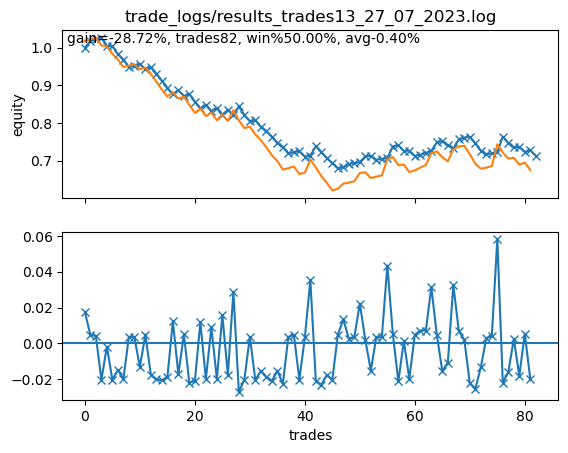

In [3]:
file="trade_logs/results_trades13_27_07_2023.log"
equity,profits = read_results(file,skiprows=250)
plot_profits(equity,profits,file)

In [10]:
import datetime,time
import mplfinance as mpf
from aver6_funcs import get_data

In [11]:
file = "trade_logs/results_trades13_27_07_2023.log"
with open(file,"r") as f:
    data = f.readlines()
split_data = [d[:-1].split(",") for d in data[250:]]

In [28]:
%%time
stored_data = []
for ticker,interval,openprice,closeprice,dfname,starttime,exittime,reason in split_data[0:-10]:
    dt0 = datetime.datetime.strptime(starttime[9:-3],'%Y-%m-%d_%H:%M:%S')
    ts0 = int(dt0.timestamp()*1000)
    dt1 = datetime.datetime.strptime(starttime[9:20]+exittime[8:-3],"%Y-%m-%d_%H:%M:%S")
    ts1 = int(dt1.timestamp()*1000)
    df5m = get_data(ticker,interval,start_time=ts0-25*60*1000,limit=9,offset=8*3600_000,try_interval=0) 
    df1m = get_data(ticker,"1m",start_time=ts0-25*60*1000,limit=7*5+10,offset=8*3600_000,try_interval=0) 
    stored_data.append( (df5m.copy(),df1m.copy() ))
    time.sleep(0.05) 

CPU times: total: 1.14 s
Wall time: 21.2 s


In [87]:
%%time

opens=[]
closes=[]
counter=0
changes=[]
for ticker,interval,openprice,closeprice,dfname,starttime,exittime,reason in split_data[0:-10]:
    #print(ticker,interval,openprice,closeprice,dfname,starttime,exittime,reason) 
    dt0 = datetime.datetime.strptime(starttime[9:-3],'%Y-%m-%d_%H:%M:%S')
    ts0 = int(dt0.timestamp()*1000)
    dt1 = datetime.datetime.strptime(starttime[9:20]+exittime[8:-3],"%Y-%m-%d_%H:%M:%S")
    ts1 = int(dt1.timestamp()*1000)
    #ts0,ts1
    df5m,df1m = stored_data[counter]
    counter+=1
    df5m_loc0 = 4 # loc of the very last candle stick
    df1m_loc0 = 24 # loc of the very last candle stick
    enter_price=df1m.iloc[df1m_loc0].Close
    end_price=None
    tp=0.015
    sl=-0.005
    prev_vol=df1m.iloc[df5m_loc0].Volume
    assert (df5m_loc0-2)>=0 
    if df5m.iloc[df5m_loc0].Volume<df5m.iloc[df5m_loc0-1].Volume:continue
    if df5m.iloc[df5m_loc0].Volume<df5m.iloc[df5m_loc0-2].Volume:continue
    if df5m.iloc[df5m_loc0].Volume<df5m.iloc[df5m_loc0-2].Volume+df5m.iloc[df5m_loc0-1].Volume:continue
    for i,( op,hi,lo,cl,vol) in enumerate(df1m.iloc[df1m_loc0+1:].values):
        if lo<=(enter_price*(1+sl)):
            end_price=(enter_price*(1+sl))#lo
            break
        #if vol<prev_vol:
        #    break
        if hi>=(enter_price*(1+tp)):
            end_price=(enter_price*(1+tp))#hi*0.5+0.5*(enter_price*(1+tp))#hi
            break
    if end_price is None:
        end_price=cl
    final_result = (end_price-enter_price)/enter_price
    changes.append( final_result )
    
    print(f"{final_result:+.2%}",ticker,i) 
    #if final_result>0.014:break
    #if counter >25:break

-0.50% BONDUSDT 1
-0.50% AKROUSDT 0
-0.50% PNTUSDT 0
-0.50% BONDUSDT 1
+0.08% LOOMUSDT 19
-0.05% SCUSDT 19
-0.41% ANKRUSDT 19
-0.50% PLAUSDT 0
-0.50% VGXUSDT 1
-0.50% PNTUSDT 5
+1.50% PLAUSDT 0
-0.50% HIFIUSDT 0
-0.50% AKROUSDT 1
-0.50% PLAUSDT 0
+0.00% SHIBUSDT 19
-0.50% PNTUSDT 11
-0.50% PLAUSDT 2
-0.50% SHIBUSDT 6
-0.50% ONGUSDT 14
-0.50% PUNDIXUSDT 1
-0.50% REIUSDT 0
-0.50% POWRUSDT 7
-0.50% RIFUSDT 1
+1.50% ONGUSDT 2
+1.50% ONGUSDT 2
-0.50% PUNDIXUSDT 6
-0.50% WANUSDT 0
-0.50% STEEMUSDT 3
-0.50% KP3RUSDT 0
+1.50% BONDUSDT 1
+1.50% REIUSDT 0
-0.50% BONDUSDT 0
+1.50% REIUSDT 0
-0.50% VGXUSDT 1
-0.18% ASTRUSDT 19
-0.50% VGXUSDT 4
-0.50% VGXUSDT 0
-0.50% ONGUSDT 2
+1.50% FUNUSDT 1
-0.50% PNTUSDT 0
+1.50% KP3RUSDT 11
+1.50% DCRUSDT 0
+1.50% KP3RUSDT 0
-0.50% FARMUSDT 0
+1.50% MOBUSDT 3
+1.50% ASRUSDT 0
-0.50% ASRUSDT 0
-0.50% VGXUSDT 0
CPU times: total: 15.6 ms
Wall time: 70 ms


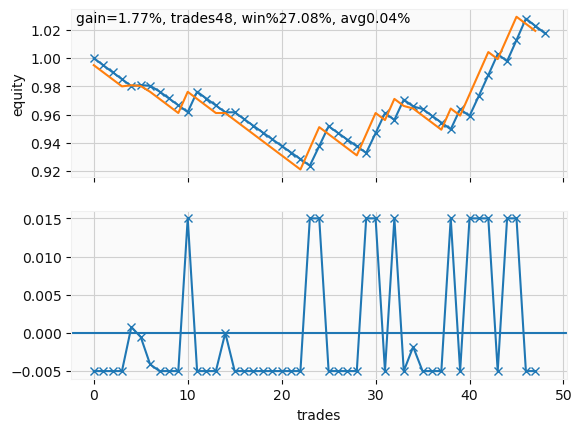

In [88]:
startingfund=1
endingfund = startingfund
equity = [startingfund]
for p in changes:
    endingfund *= (1+p)
    equity.append(endingfund)
plot_profits(equity,np.asarray(changes))

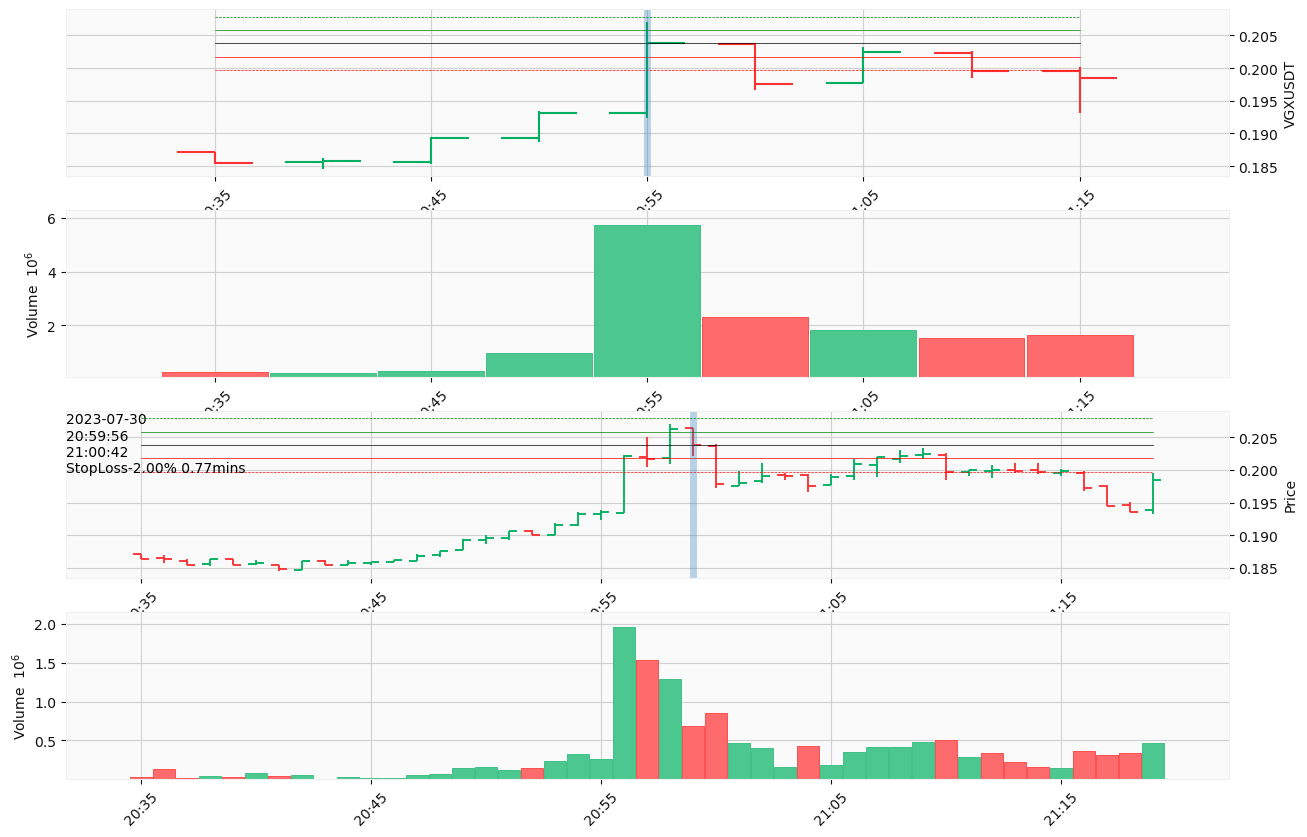

In [86]:
fig = mpf.figure(style='yahoo', figsize=(15,10))
ax1 = fig.add_subplot(4,1,1)
ax2 = fig.add_subplot(4,1,2,sharex=ax1)
ax3 = fig.add_subplot(4,1,3)
ax4 = fig.add_subplot(4,1,4,sharex=ax3)
x=df5m_loc0;c0=df5m.Close*0
apds = [ mpf.make_addplot(c0+df5m.iloc[x].Close,ax=ax1,color='k',type='line',width=0.5, secondary_y=False),
        mpf.make_addplot(c0+df5m.iloc[x].Close*1.01,ax=ax1,color='g',type='line',width=0.5, secondary_y=False),
        mpf.make_addplot(c0+df5m.iloc[x].Close*0.99,ax=ax1,color='r',type='line',width=0.5, secondary_y=False),
        mpf.make_addplot(c0+df5m.iloc[x].Close*1.02,ax=ax1,color='g',type='line',linestyle="--",width=0.5, secondary_y=False),
        mpf.make_addplot(c0+df5m.iloc[x].Close*0.98,ax=ax1,color='r',type='line',linestyle="--",width=0.5, secondary_y=False),
       ]
mpf.plot(df5m,addplot=apds,ax=ax1,ylabel=f"{ticker}",volume=ax2)
x=df1m_loc0;c0=df1m.Close*0
apds = [ mpf.make_addplot(c0+df1m.iloc[x].Close,ax=ax3,color='k',type='line',width=0.5, secondary_y=False),
        mpf.make_addplot(c0+df1m.iloc[x].Close*1.01,ax=ax3,color='g',type='line',width=0.5, secondary_y=False),
        mpf.make_addplot(c0+df1m.iloc[x].Close*0.99,ax=ax3,color='r',type='line',width=0.5, secondary_y=False),
        mpf.make_addplot(c0+df1m.iloc[x].Close*1.02,ax=ax3,color='g',type='line',linestyle="--",width=0.5, secondary_y=False),
        mpf.make_addplot(c0+df1m.iloc[x].Close*0.98,ax=ax3,color='r',type='line',linestyle="--",width=0.5, secondary_y=False),
       ]
mpf.plot(df1m,addplot=apds,ax=ax3,volume=ax4)
strr = f"{starttime[9:9+10]}\n{starttime[9+11:-3]}\n{exittime[8:-3]}"
strr += f"\n{reason[18:]} {(ts1-ts0)/60_000:.2f}mins"
ax3.text(0.0,0.99,strr, transform=ax3.transAxes,va="top");
ax1.axvline(df5m_loc0,ymax=0.99,lw=5,alpha=0.3)
ax3.axvline(df1m_loc0,ymax=0.99,lw=5,alpha=0.3)
if (ts1-ts0)//60_000<19 and (ts1-ts0)//60_000>0:
    ax3.axvline(df1m_loc0+(ts1-ts0)//60_000,ymax=0.99,lw=5,alpha=0.3)

# end of file

# retrieve 1m candlesticks from 5m entries, and see how to trade it

In [61]:
from aver6_funcs import get_data
import time

In [62]:
df = get_data("BTCUSDT","1s",start_time=int(time.time())*1000-3600_000,limit=3,offset=8*3600_000)
df

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-30 22:17:01,29305.88,29305.89,29305.88,29305.88,0.49416
2023-07-30 22:17:02,29305.89,29305.89,29305.88,29305.88,5.63815
2023-07-30 22:17:03,29305.88,29305.89,29305.88,29305.89,0.01195


In [63]:
newtime= df.iloc[-1].name.value//1000_000

In [64]:
df1 = get_data("BTCUSDT","1s",start_time=newtime-8*3600_000,limit=3,offset=8*3600_000,try_interval=0)
df1

,Open,High,Low,Close,Volume
Date,,,,,
2023-07-30 22:17:03,29305.88,29305.89,29305.88,29305.89,0.01195
2023-07-30 22:17:04,29305.88,29305.88,29305.88,29305.88,0.00262
2023-07-30 22:17:05,29305.88,29305.88,29305.88,29305.88,0.08425
